# Experiment: Model with 3 classes (clean, damaged, dirt)

## Unbalaced classes

In [1]:
#load images
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, optimizers, callbacks
import matplotlib.pyplot as plt 
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from PIL import Image
import os
%matplotlib inline

2023-08-31 10:22:58.705448: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 10:22:58.758057: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-31 10:22:58.760207: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-31 10:22:59.874617: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
batch_size = 32
train_data_dir = "raw_data/exp-training-data/"
test_data_dir = "raw_data/exp-val-data/"

train_data = image_dataset_from_directory(
  train_data_dir,
  #labels = "inferred",
  label_mode = "int",  
  seed=123,
  image_size=(225, 225),
  batch_size=batch_size,
  #validation_split=0.2,
  #subset='both'
) 
val_data = image_dataset_from_directory(
   test_data_dir,
   #labels = "inferred",
   label_mode = "int",
   seed=123,
   image_size=(225, 225),
   batch_size=batch_size,
 )

#train_data = train_ds[0]
#val_data = train_ds[1]

Found 627 files belonging to 3 classes.
Found 90 files belonging to 3 classes.


In [3]:
classes1 = train_data.class_names
classes1

['clean', 'damage', 'dirt']

In [4]:
classes2 = val_data.class_names
classes2

['clean', 'damage', 'dirt']

### Model

In [5]:
# We'll use a model with the same convolutional layers, but we'll add Augmentation layers before that

model_multi = Sequential()

model_multi.add(layers.Rescaling(1./255, input_shape = (225, 225, 3)))

# Data Augmentation Layers

model_multi.add(layers.RandomFlip("horizontal"))
model_multi.add(layers.RandomZoom(0.1))
model_multi.add(layers.RandomTranslation(0.2, 0.2))
model_multi.add(layers.RandomRotation(0.1))


# Convolutional Layers

model_multi.add(layers.Conv2D(filters = 32, kernel_size = (3,3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_multi.add(layers.Conv2D(filters = 32, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )


model_multi.add(layers.Conv2D(filters = 64, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_multi.add(layers.Conv2D(filters = 128, kernel_size = (3,3), input_shape = (225, 225, 3), activation="relu", padding = "same"))
model_multi.add(layers.MaxPooling2D(pool_size=(2, 2), padding = "same") )

model_multi.add(layers.Flatten())

model_multi.add(layers.Dense(64, activation="relu"))

model_multi.add(layers.Dropout(0.5))

model_multi.add(layers.Dense(3, activation="softmax"))

In [6]:
model_multi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 225, 225, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 225, 225, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 225, 225, 3)       0         
                                                                 
 random_translation (Random  (None, 225, 225, 3)       0         
 Translation)                                                    
                                                                 
 random_rotation (RandomRot  (None, 225, 225, 3)       0         
 ation)                                                          
                                                                 
 conv2d (Conv2D)             (None, 225, 225, 32)      8

In [7]:
adam = optimizers.Adam(learning_rate = 0.001)

model_multi.compile(loss= SparseCategoricalCrossentropy(),
              optimizer= adam,
              metrics=['accuracy'])

In [8]:
MODEL = "model_multiclass_clean_damage_dirt_310823_v1"

modelCheckpoint = callbacks.ModelCheckpoint("{}.h5".format(MODEL), monitor="val_loss", verbose=0, save_best_only=True)

LRreducer = callbacks.ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=3, verbose=1, min_lr=0)

EarlyStopper = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=0, restore_best_weights=True)

In [9]:
#new weights - remove snow images, and macro pic of bird
clean = 150 
damage = 133
dirt = 344
total = clean + damage + dirt
print(f'total: {total}')
clean_weight =  (clean/total)**-1
damage_weight = (damage/total)**-1
dirt_weight = (dirt/total)**-1
print(f"clean weight: {clean_weight}")
print(f"damage weight: {damage_weight}")
print(f"dirt weight: {dirt_weight}")

total: 627
clean weight: 4.18
damage weight: 4.714285714285714
dirt weight: 1.822674418604651


In [10]:
%%time
#'clean', 'damage', 'dirt'
history_multi = model_multi.fit(
        train_data,
        epochs=30,
        validation_data=val_data,
        callbacks = [modelCheckpoint, LRreducer, EarlyStopper],
        class_weight = {
            0: 4.2,
            1: 4.3,
            2: 1.8
        }
        )


Epoch 1/30
20/20 [==============================] - 24s 1s/step - loss: 3.3434 - accuracy: 0.3206 - val_loss: 1.0605 - val_accuracy: 0.3778 - lr: 0.0010
Epoch 2/30


/home/emiliamelo/.pyenv/versions/3.10.6/envs/solar_project/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 23s 1s/step - loss: 3.0269 - accuracy: 0.5056 - val_loss: 1.0859 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 3/30
20/20 [==============================] - 23s 1s/step - loss: 2.7239 - accuracy: 0.6108 - val_loss: 0.9665 - val_accuracy: 0.5222 - lr: 0.0010
Epoch 4/30
20/20 [==============================] - 24s 1s/step - loss: 2.7235 - accuracy: 0.6124 - val_loss: 0.9347 - val_accuracy: 0.5444 - lr: 0.0010
Epoch 5/30
20/20 [==============================] - 25s 1s/step - loss: 2.6990 - accuracy: 0.6220 - val_loss: 0.9333 - val_accuracy: 0.5778 - lr: 0.0010
Epoch 6/30
20/20 [==============================] - 26s 1s/step - loss: 2.7675 - accuracy: 0.6188 - val_loss: 1.0102 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 7/30
20/20 [==============================] - 27s 1s/step - loss: 2.6377 - accuracy: 0.6396 - val_loss: 0.8531 - val_accuracy: 0.6222 - lr: 0.0010
Epoch 8/30
20/20 [==============================] - 26s 1s/step - loss: 2.6542 - accuracy: 0.

In [11]:
#improvement = (0.51 - (1/3))/(1/3)
#improvement

In [12]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

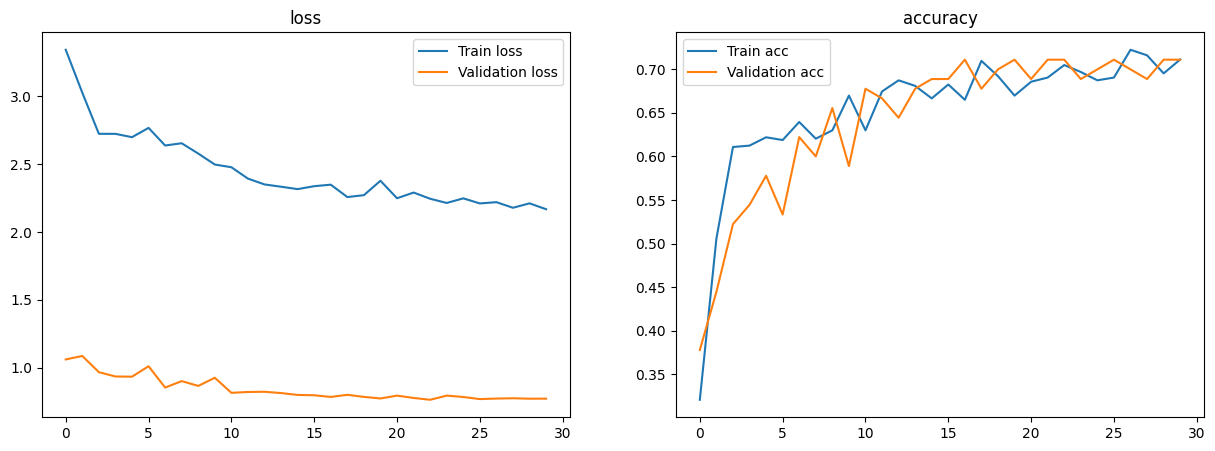

In [13]:
plot_history(history_multi)

### Helper functions

In [14]:
def find_index_of_max_element(input_list):
    max_value = max(input_list)
    max_index = input_list.index(max_value)
    return max_index

In [15]:
def predictImage_multiclass(url, model):

  # Takes an image and a model

  img = url
  img = img_to_array(img)
  img = img.reshape((-1, 225, 225, 3))
  res = model.predict(img)
  print(f"Probabilities: ")
  names_of_classes = class_names
  print(f"{names_of_classes}")
  print(f"{res[0]}")
  print(f"Result: {names_of_classes[find_index_of_max_element(res[0].tolist())]}")  
  return res 

In [16]:
# img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (4).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_clean_1,model_multi)
# plt.imshow(img_clean_1);

In [17]:
# img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (12).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_clean_1,model_multi)
# plt.imshow(img_clean_1);

In [18]:
# img_clean_1 = load_img(f"raw_data/training-data/clean/Cleaan (21).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_clean_1,model_multi)
# plt.imshow(img_clean_1);

### Snow

In [19]:
# img_snow = load_img(f"raw_data/training-data/solar/Solar (3).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_snow,model_multi)
# plt.imshow(img_snow);

In [20]:
# img_snow = load_img(f"raw_data/training-data/solar/Solar (12).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_snow,model_multi)
# plt.imshow(img_snow);

In [21]:
# img_snow = load_img(f"raw_data/training-data/solar/Solar (33).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_snow,model_multi)
# plt.imshow(img_snow);

### Damage

In [22]:
# img_electrical = load_img(f"raw_data/training-data/electrical/Electrical (29).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_electrical,model_multi)
# plt.imshow(img_electrical);

In [23]:
# img_physical = load_img(f"raw_data/training-data/physical_damaged/Physical-damaged (37).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

In [24]:
# img_physical = load_img(f"raw_data/training-data-exp/damage/Electrical (23).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

### Bird or dust


In [25]:
##pics bird 37,55,59,  --> macro pic on brid drop --> predicting wrong class
# pic 65
# img_physical = load_img(f"raw_data/training-data/bird/Bird (65).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

In [26]:
# img_physical = load_img(f"raw_data/training-data/bird/Bird (5).jpeg", target_size=(225, 225))
# predictImage_multiclass(img_physical,model_multi)
# plt.imshow(img_physical);

In [27]:
#img_physical = load_img(f"raw_data/training-data-exp/dirt/Bird (47).jpeg", target_size=(225, 225))
#predictImage_multiclass(img_physical,model_multi)
#plt.imshow(img_physical);

In [28]:
def predictImage_multiclass(url, model):

  # Takes an image and a model

  img = url
  img = img_to_array(img)
  img = img.reshape((-1, 225, 225, 3))
  res = model.predict(img)
  print(f"Probabilities: ")
  names_of_classes = class_names
  print(f"{names_of_classes}")
  print(f"{res[0]}")
  print(f"Result: {names_of_classes[find_index_of_max_element(res[0].tolist())]}")  
  return res 

In [29]:
import numpy as np
from tensorflow.math import confusion_matrix
from sklearn.metrics import classification_report


predictions = np.array([])
print(predictions.shape)
labels =  np.array([])
for x, y in val_data:
    
  pred = model_multi.predict(x)
  pred = np.argmax(pred, axis=-1)
  print(f"pred {pred.shape}")
  predictions = np.concatenate([predictions, pred ])
  label =  np.argmax(y.numpy(), axis=-1)
  print(f"label shape {label.shape}")
  labels = np.concatenate([labels, y])  #np.argmax(y.numpy()

report = classification_report(labels, predictions, target_names=classes1)

print(report)

(0,)
1/1 [==============================] - 0s 399ms/step
pred (32,)
label shape ()
1/1 [==============================] - 0s 293ms/step
pred (32,)
label shape ()
1/1 [==============================] - 0s 312ms/step
pred (26,)
label shape ()
              precision    recall  f1-score   support

       clean       0.66      0.90      0.76        30
      damage       0.89      0.53      0.67        30
        dirt       0.68      0.70      0.69        30

    accuracy                           0.71        90
   macro avg       0.74      0.71      0.71        90
weighted avg       0.74      0.71      0.71        90



In [30]:
confusion_matrix(labels=labels, predictions=predictions).numpy()


array([[27,  0,  3],
       [ 7, 16,  7],
       [ 7,  2, 21]], dtype=int32)

## Test data

In [31]:
# batch_size = 8
# test_data_dir = "raw_data/exp-test-data/"

# test_data = image_dataset_from_directory(
#   test_data_dir,
#   #labels = "inferred",
#   label_mode = "int",  
#   seed=123,
#   image_size=(225, 225),
#   batch_size=batch_size,
# ) 


In [32]:
# predictions = np.array([])
# print(predictions.shape)
# labels =  np.array([])
# for x, y in test_data:
    
#   pred = model_multi.predict(x)
#   pred = np.argmax(pred, axis=-1)
#   print(f"pred {pred.shape}")
#   predictions = np.concatenate([predictions, pred ])
#   label =  np.argmax(y.numpy(), axis=-1)
#   print(f"label shape {label.shape}")
#   labels = np.concatenate([labels, y])  #np.argmax(y.numpy()

# report = classification_report(labels, predictions, target_names=classes1)

# print(report)

In [33]:
confusion_matrix(labels=labels, predictions=predictions).numpy()

array([[27,  0,  3],
       [ 7, 16,  7],
       [ 7,  2, 21]], dtype=int32)